<a href="https://colab.research.google.com/github/TienLungSun/Intelligent-Robot/blob/main/LearnPPO-AC/5.%20PPO%20(MLAgent_10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt
from mlagents_envs.environment import UnityEnvironment

In [ ]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda GeForce GTX 1660 SUPER


In [ ]:
# state = input of NN, action = output of NN
N_STATES  = 8
N_ACTIONS =2

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)

In [ ]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        
        self.actor = nn.Sequential(
            nn.Linear(N_STATES, 128),
            nn.LayerNorm(128),
            nn.Linear(128, 128),
            nn.LayerNorm(128),
            nn.Linear(128, N_ACTIONS)
        )
        self.log_std = nn.Parameter(torch.ones(1, N_ACTIONS) * 0.0)
        self.apply(init_weights)
    
    def forward(self, x):
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist

In [ ]:
net = Net().to(device)

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

### function to interacts with Unity 20 steps

In [ ]:
NoAgents = 3 #My Unity scene has three training environment
NoSteps = 20

In [ ]:
def collect_training_data (NoAgents, NoSteps, N_STATES, N_ACTIONS, env, net):
    # collect (s,a,r,s1) from 20 good interactions with Unity
    a = torch.FloatTensor([[0]]*NoAgents) #create NoAgents by 1 tensor
    b = torch.FloatTensor([[0]*N_ACTIONS]*NoAgents) 
    c = torch.FloatTensor([[0]*N_STATES]*NoAgents) 
    values = rewards = masks = [a]*NoSteps
    log_probs = actions = [b]*NoSteps
    states =[c]*NoSteps

    step = 0  #index 0
    DecisionSteps, TerminalSteps = env.get_steps(behaviorName)
    while(step < NoSteps): #try to run 20 good steps
        if(len(DecisionSteps) == 0): #we have no decision agents
            env.reset() 
            DecisionSteps, TerminalSteps = env.get_steps(behaviorName)
            #continue next while loop without increase step
        else:  # we have decision agents
            lst = list(DecisionSteps.agent_id) + list(TerminalSteps.agent_id)
            if(len(list(set(lst))) != NoAgents): 
                #if this step misses some agents, then only interacts with Unity 
                #but do not collect data
                s = DecisionSteps.obs[0]  
                s = torch.FloatTensor(s).to(device)    
                dist = net(s)
                a = dist.sample() 
                env.set_actions(behaviorName, a.cpu().detach().numpy() )   
                env.step()
                DecisionSteps, TerminalSteps = env.get_steps(behaviorName)
                #continue next while loop without increase step
            else: 
                #this step includes all agents, collect (s, a, r, s1)
                s = DecisionSteps.obs[0]  
                s = torch.FloatTensor(s).to(device)         
                dist = net(s)
                a = dist.sample()
                log_prob = dist.log_prob(a)
                for idx in range(len(DecisionSteps)):
                    #find decision agents and record their state, value and actions
                    AgentID = DecisionSteps.agent_id[idx]
                    states[step][AgentID]=s[idx]
                    values[step][AgentID]= 0.2 # value will be estimated by critic NN later 
                    actions[step][AgentID]=a[idx]
                    log_probs[step][AgentID]=log_prob[idx]
                env.set_actions(behaviorName, a.cpu().detach().numpy() )   
                env.step()
                DecisionSteps, TerminalSteps = env.get_steps(behaviorName)
                #if next step misses some agents, then do not update step
                lst = list(DecisionSteps.agent_id) + list(TerminalSteps.agent_id)
                if(len(list(set(lst))) != NoAgents):
                    continue #skip this step, run next while loop without increase step index
                else:
                    #collect reward of this action from next decision and terminal steps
                    if(len(TerminalSteps) >0):
                        #if next step has terminal agents, then collect terminal agents first
                        r = TerminalSteps.reward
                        r = torch.FloatTensor(r).unsqueeze(1)
                        for idx in range(len(TerminalSteps)):
                            AgentID = TerminalSteps.agent_id[idx]
                            rewards[step][AgentID]=r[idx]
                            masks[step][AgentID]= 0
                    #collect from decision steps
                    r = DecisionSteps.reward 
                    r = torch.FloatTensor(r).unsqueeze(1)
                    for idx in range(len(DecisionSteps)):
                        AgentID = DecisionSteps.agent_id[idx] 
                        if(rewards[step][AgentID] == None): #this agent is not in terminal step
                            rewards[step][AgentID]= r[idx]
                            masks[step][AgentID]= 1
                    step = step + 1 #increase step and run next while
    return  states, actions, log_probs, values, rewards, masks

### GAE

In [ ]:
def compute_gae(NoSteps, next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(NoSteps)):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

### PPO optimization

In [ ]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantages[rand_ids, :]

In [ ]:
def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    print("epoch:")
    for epoch in range(ppo_epochs):
        print(epoch, end = ", ")
        for batch_state, batch_action, batch_old_log_probs, batch_return, batch_advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist = net(batch_state.to(device))
            batch_action = dist.sample()
            batch_new_log_probs = dist.log_prob(batch_action)
            ratio = (batch_new_log_probs - batch_old_log_probs.to(device)).exp()
            surr1 = ratio * batch_advantage.to(device)
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * batch_advantage.to(device)
            actor_loss  = - torch.min(surr1, surr2).mean()
            optimizer.zero_grad()
            actor_loss.backward()
            optimizer.step()
    return float(actor_loss)

### try one iteration

In [ ]:
env = UnityEnvironment(file_name= None, base_port=5004)

In [ ]:
env.reset()
behaviorNames = list(env.behavior_specs.keys())
behaviorName = behaviorNames[0]
print(behaviorName)

3DBall?team=0


In [ ]:
states, actions, log_probs, values, rewards, masks = collect_training_data (NoAgents, NoSteps, N_STATES, N_ACTIONS, env, net)
print(len(log_probs), log_probs[0].shape)
print(len(values), values[0].shape)
print(len(rewards), rewards[0].shape)
print(len(masks), masks[0].shape)
print(len(states), states[0].shape)
print(len(actions), actions[0].shape)

20 torch.Size([3, 2])
20 torch.Size([3, 1])
20 torch.Size([3, 1])
20 torch.Size([3, 1])
20 torch.Size([3, 8])
20 torch.Size([3, 2])


In [ ]:
next_value = torch.FloatTensor([[0.2]]*NoAgents) 
returns = compute_gae(NoSteps, next_value, rewards, masks, values, gamma=0.99, tau=0.95)

In [ ]:
returns   = torch.cat(returns).detach()
log_probs = torch.cat(log_probs).detach()
values    = torch.cat(values).detach()
states    = torch.cat(states) 
actions   = torch.cat(actions)
advantages = returns - values

In [ ]:
print(len(returns), returns[0].shape)
print(len(log_probs), log_probs[0].shape)
print(len(values), values[0].shape)
print(len(states), states[0].shape)
print(len(actions), actions[0].shape)
print(len(advantages), advantages[0].shape)

60 torch.Size([1])
60 torch.Size([2])
60 torch.Size([1])
60 torch.Size([8])
60 torch.Size([2])
60 torch.Size([1])


In [ ]:
loss = ppo_update(50, 5, states, actions, log_probs, returns, advantages, clip_param=0.2)

epoch:
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

In [ ]:
env.close()

# run PPO optimization multiple iterations

In [ ]:
env = UnityEnvironment(file_name= None, base_port=5004)

In [ ]:
env.reset()
behaviorNames = list(env.behavior_specs.keys())
behaviorName = behaviorNames[0]
print(behaviorName)

3DBall?team=0


In [ ]:
NoSteps = 50

In [ ]:
lossLst = []
frame_idx  = 0
max_frames = 200   

while (frame_idx < max_frames):
    print("\nframe idx = ", frame_idx)
    print("Interacts with Unity to collect training data")
    states, actions, log_probs, values, rewards, masks = collect_training_data (NoAgents, NoSteps, N_STATES, N_ACTIONS, env, net)
    next_value = torch.FloatTensor([[0.2]]*NoAgents) 
    
    print("Compute GAE of these training data set")
    returns = compute_gae(NoSteps, next_value, rewards, masks, values, gamma=0.99, tau=0.95)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states) 
    actions   = torch.cat(actions)
    advantages = returns - values
    
    print("Optimize NN with PPO")
    loss = ppo_update(50, 5, states, actions, log_probs, returns, advantages, clip_param=0.2)
    lossLst.append(loss)
    
    frame_idx += NoSteps

frame idx =  0
Interacts with Unity to collect training data
Compute GAE of these training data set
Optimize NN with PPO
epoch:
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, frame idx =  50
Interacts with Unity to collect training data
Compute GAE of these training data set
Optimize NN with PPO
epoch:
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, frame idx =  100
Interacts with Unity to collect training data
Compute GAE of these training data set
Optimize NN with PPO
epoch:
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, frame idx =  150
Interacts with Unity to co

In [ ]:
env.close()

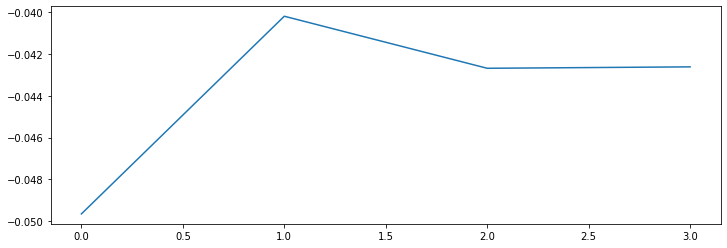

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(lossLst)
plt.show()